In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Add the root directory of the package to sys.path
sys.path.append('/Users/zzhang/Workspace/SpyDust/')
sys.path.append('../')

from SpyDust.Grain import *

l_a computed
readPAH computed
Loaded previously computed Jpeisrf arrays from file.
Tev table already exists at /Users/zzhang/Workspace/SpyDust/SpyDust/Data_Files/Tev_30a_30chi.txt.
I(Zg<0, parabolic) stored
I(rot, e, Zg <> 0) stored
I(Zg<0, parabolic) stored
I(rot, e, Zg <> 0) stored
Gaunt factor stored


/Users/zzhang/Workspace/SpyDust/SpyDust/free_free.py:27: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(gff_data_file, delim_whitespace=True, comment=';', header=None, names=['gamma2', 'u', 'gff'])


In [2]:
grain_obj = grain_distribution()
f_a_beta = grain_obj.shape_and_size_dist(6, a_weighted=True, normalize=True)
a_tab = grain_obj.a_tab
beta_tab = grain_obj.beta_tab

In [5]:
from SpyDust.util import cgsconst
from SpyDust.AngMomDist import log_f_rot
from SpyDust.charge_dist import charge_dist

aind = 5
a = a_tab[aind]
beta = beta_tab[np.argmax(f_a_beta[aind, :])]

a_min = a_tab[0]
a_max = a_tab[-1]
beta_min = beta_tab[0]
beta_max = beta_tab[-1]

a_list = np.linspace(a_min, a_max, 100)
beta_list = np.linspace(beta_min, beta_max, 100)


In [6]:
# ---------- helpers -------------------------------------------------
def _normalise(w):
    """Turn any non–negative weight array into a PDF."""
    w = np.asarray(w, dtype=float)
    if np.any(w < 0):                       # sanity check
        raise ValueError("Weights must be non-negative.")
    s = w.sum()
    if s == 0:
        raise ValueError("All weights are zero → cannot normalise.")
    return w / s

# ---------- 1. Power-law over discrete points -----------------------
def power_law_pdf(x, gamma=1.0, decreasing=True):
    """
    P(x_i) ∝ x_i^{±gamma}.  
    decreasing=True  → negative slope (x^{-γ})  
    decreasing=False → positive slope (x^{+γ})
    """
    x = np.asarray(x)
    if np.any(x <= 0):
        raise ValueError("Power-law needs strictly positive x.")
    weights = x ** (-gamma if decreasing else gamma)
    return _normalise(weights)

# ---------- 2. Peaked (Gaussian) ------------------------------------
def gaussian_pdf(x, mu=None, sigma=None):
    """
    Discrete Gaussian on your grid.
    By default, centre in the middle of the range and
    use σ = 0.2 · (x_max – x_min).
    """
    x = np.asarray(x, dtype=float)
    if mu   is None: mu   = 0.5*(x.min() + x.max())
    if sigma is None: sigma = 0.2*(x.max() - x.min())
    weights = np.exp(-0.5*((x - mu)/sigma)**2)
    return _normalise(weights)

In [7]:
CNM_params = {'nh' : 30, 'T': 100., 'Chi': 1, 'xh': 1.2e-3, 'xC': 3e-4, 'y' : 0, 'gamma': 0, 'dipole': 9.3, 'line':7}

In [13]:
from util import homogeneous_dist
from full_Stokes import full_Stokes_SED

In [19]:
class spdust_conditional_SED:
    def __init__(self, obs_omegas, int_dist_func=homogeneous_dist, ext_dist_func=homogeneous_dist, impulse=None):
        self.obs_omegas = obs_omegas
        self.int_dist_func = int_dist_func
        self.ext_dist_func = ext_dist_func
        self.impulse = impulse

    @staticmethod
    def generate_loglog_rot_dist_func(env, a, beta, mu, ip):
        fZ = charge_dist(env, a, beta)
        mu_ip = np.array([mu * np.sqrt(ip)])
        mu_op = np.array([mu * np.sqrt(1 - ip)])
        log_Omegas, log_rot_dist = log_f_rot(env, a, beta, fZ, mu_ip, mu_op, omega_min=1e7, omega_max=3e13, Nomega=1000)
        return log_Omegas, log_rot_dist

    def generate(self, env, a, beta, mu, ip):
        self.log_omegas, self.log_rot_dist = self.generate_loglog_rot_dist_func(env, a, beta, mu, ip)
        spdust_model = full_Stokes_SED(rot_freq_grid=self.log_omegas, rot_dist_grid=self.log_rot_dist,
                                       log_freq=True, log_dist=True)
        result = spdust_model.generate_SED(self.obs_omegas, beta, ip, mu**2,
                                            internal_dist=self.int_dist_func, 
                                            impulse=self.impulse,
                                            external_dist=self.ext_dist_func, 
                                            max_workers=1, 
                                            full_Stokes=False)

        return result

In [20]:
obs_omegas_min = 2*np.pi*3e9
obs_omegas_max = 2*np.pi*3e11
obs_omegas_num = 1000
obs_omegas = makelogtab(obs_omegas_min , obs_omegas_max , obs_omegas_num)

spd_model = spdust_conditional_SED(obs_omegas)

debye = cgsconst.debye
env = CNM_params
dip_per_at = env['dipole'] / np.sqrt(N_C(1e-7) + N_H(1e-7)) * debye


beta = beta_min

In [ ]:
def size_ensemble_positive_power():
    spd_SED = 0.
    a_pdf = power_law_pdf(a_list, decreasing=False)
    for i, a in enumerate(a_list):
        fZ = charge_dist(CNM_params, a, beta)
        Z2 = np.sum(fZ[0, :]**2 * fZ[1, :])
        mu_rms = rms_dipole(a, beta, Z2, dip_per_at)
        spd_SED += spd_model.generate(CNM_params, a, beta, mu_rms, 2/3) * a_pdf[i]
    return spd_SED

def size_ensemble_negative_power():
    spd_SED = 0.
    a_pdf = power_law_pdf(a_list, decreasing=True)
    for i, a in enumerate(a_list):
        fZ = charge_dist(CNM_params, a, beta)
        Z2 = np.sum(fZ[0, :]**2 * fZ[1, :])
        mu_rms = rms_dipole(a, beta, Z2, dip_per_at)
        spd_SED += spd_model.generate(CNM_params, a, beta, mu_rms, 2/3) * a_pdf[i]
    return spd_SED

def size_ensemble_gaussian():
    spd_SED = 0.
    a_pdf = gaussian_pdf(a_list, mu=0.5*(a_min + a_max), sigma=0.2*(a_max - a_min))
    for i, a in enumerate(a_list):
        fZ = charge_dist(CNM_params, a, beta)
        Z2 = np.sum(fZ[0, :]**2 * fZ[1, :])
        mu_rms = rms_dipole(a, beta, Z2, dip_per_at)
        spd_SED += spd_model.generate(CNM_params, a, beta, mu_rms, 2/3) * a_pdf[i]
    return spd_SED

In [30]:
SED_posi = size_ensemble_positive_power()
SED_nega = size_ensemble_negative_power()
SED_gaus = size_ensemble_gaussian()

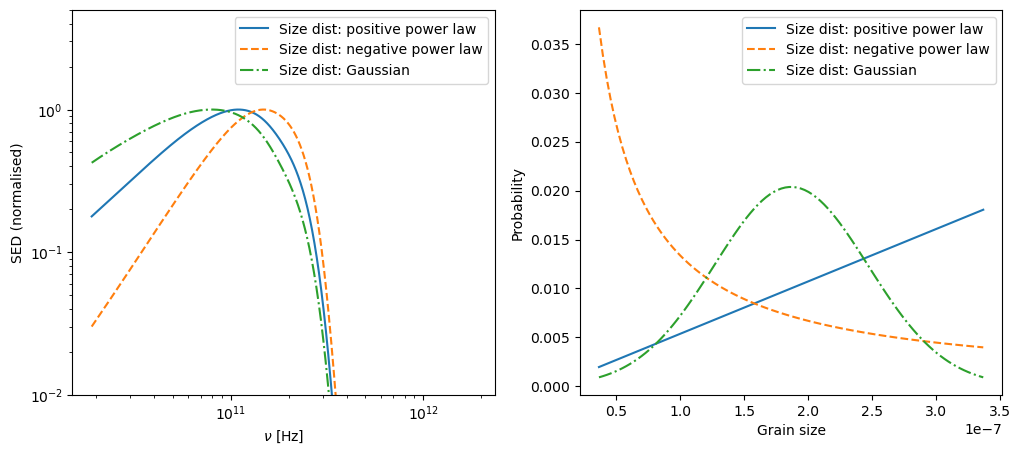

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(obs_omegas, SED_posi[0]/np.max(SED_posi[0]), label='Size dist: positive power law', linestyle='-')
ax[0].plot(obs_omegas, SED_nega[0]/np.max(SED_nega[0]), label='Size dist: negative power law', linestyle='--')
ax[0].plot(obs_omegas, SED_gaus[0]/np.max(SED_gaus[0]), label='Size dist: Gaussian', linestyle='-.')
ax[0].legend(loc='upper right')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_ylim(1e-2, 5)
ax[0].set_xlabel(r'$\nu$ [Hz]')
ax[0].set_ylabel(r'SED (normalised)')
ax[1].plot(a_list, power_law_pdf(a_list, decreasing=False), label='Size dist: positive power law', linestyle='-')
ax[1].plot(a_list, power_law_pdf(a_list, decreasing=True), label='Size dist: negative power law', linestyle='--')
ax[1].plot(a_list, gaussian_pdf(a_list, mu=0.5*(a_min + a_max), sigma=0.2*(a_max - a_min)), label='Size dist: Gaussian', linestyle='-.')
ax[1].legend()
ax[1].set_xlabel('Grain size')
ax[1].set_ylabel('Probability')

plt.savefig('size_ensemble.png', dpi=300)



In [ ]:
'l'